# **CS 649 Intro To Big Data Exam Submission**

# **Arthkumar Patel**


In [1]:
# Import necessory modules for the code
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tt
import requests
from datetime import datetime as dt

In [2]:
pd.options.display.float_format = '{0:,.2f}'.format

In [3]:
# 2 letter abbreviation code and state full name key:value pairs
state_abbreviation = {
'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA', 'Colorado': 'CO',
'Connecticut': 'CT', 'Delaware': 'DE','Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
'New Mexico': 'NM', 'New York State': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA',
'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY' 
}

In [4]:
# Loading 4 datasets from url and dropping unnecessory columns for the given questions
url_cases = "https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_confirmed_usafacts.csv"
daily_cases = pd.read_csv(url_cases).drop(['countyFIPS','County Name','StateFIPS'],axis=1).set_index('State')

url_deaths = "https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_deaths_usafacts.csv"
daily_deaths = pd.read_csv(url_deaths).drop(['countyFIPS','County Name','StateFIPS'],axis=1).set_index('State')

url_vaccines = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv"
daily_vaccines = pd.read_csv(url_vaccines).drop(['distributed_per_hundred','daily_vaccinations_raw','daily_vaccinations',
                 'daily_vaccinations_per_million','share_doses_used','total_vaccinations_per_hundred'],axis=1)
daily_vaccines['date'] = pd.to_datetime(daily_vaccines['date'])

url_population = "https://usafactsstatic.blob.core.windows.net/public/data/covid-19/covid_county_population_usafacts.csv"
county_population = pd.read_csv(url_population).drop(['countyFIPS','County Name'],axis=1).set_index('State')

## **Question 1 : In us_state_vaccinations.csv there are some gaps in the data. Will those gaps affect the results of the following questions. If no why not. If yes explain the affect.**

### Answer 1 : These gaps are not affecting the results of the folllowing questions because in all the given questions we are only interested in the latest date's vaccination data for the analysis which is given in the dataset. You can also refer the results of Question 2-6 for confirmation of this conclusion.

### Note : I would also like to mention about missing data of some Mondays in dataset for quesion 5 & 6. This data is required for the those 2 questions but we can forward fill that data in missing values so it is not affecting the result of Question 5 & 6.

In [5]:
total_vaccines=daily_vaccines.loc[daily_vaccines.groupby('location').date.idxmax()]

## **Question 2 : The vaccination data is reported by the entire country, state, US territory and various groups like the department of defense, long term care and others. Presumably the US data includes the state data and the special group data but not the US territory data. Is the US territory data included in the US totals. Justify your answer.**

In [6]:
# Including territories with States and special groups to check whether they are included in US totals or not.
states_territories_groups_vaccines = total_vaccines[(total_vaccines['location']!='United States') & (total_vaccines['location']!='Republic of Palau') 
  & (total_vaccines['location']!='Marshall Islands') & (total_vaccines['location']!='Federated States of Micronesia') 
  & (total_vaccines['location']!='District of Columbia')]

In [7]:
# Finding Total Vaccination Sum for comparison.
print('(States + Special Group + Territory) Total Vaccination :',states_territories_groups_vaccines['total_vaccinations'].sum() )
print(' US Total Vaccinations : ',total_vaccines[total_vaccines['location']=='United States']['total_vaccinations'].sum())

(States + Special Group + Territory) Total Vaccination : 245955714.0
 US Total Vaccinations :  230768454.0


### Answer 2 : From above result we can say that if we compare the sum of 5 territories with States and Special groups' vacccinations with US total vaccinations then there is huge difference. For territories to be included in US totals both results should be eqaul. Therefore, we can say that US territories data is not included in the US totals data.

In [8]:
us_population=county_population.sum()['population']

## **Question 3 : We would like to compute the percent of the population in each state that has been fully vaccinated. Presumably the data reported got the various groups is not included in the individual state data. If we distributed the number of people fully vaccinated in those groups to the states proportionally by population how much would that change the percent of people vaccinated in each state?**

In [9]:
# Adding State Full Name column for the 2 letter state code
state_abbreviation_reverse = dict((v,k) for k,v in state_abbreviation.items())
county_population['State_Full_Name']=county_population.index.map(state_abbreviation_reverse)
state_population=county_population.groupby('State_Full_Name').sum()
state_population['Percentage_of_US_Population'] = state_population['population']*100/us_population

In [10]:
merged_states_vaccines = pd.merge(total_vaccines,state_population,left_on='location',right_index=True)

In [11]:
special_groups_vaccines = total_vaccines[(total_vaccines['location']=='Bureau of Prisons') | (total_vaccines['location']=='Dept of Defense') |
     (total_vaccines['location']=='Indian Health Svc') | (total_vaccines['location']=='Long Term Care') | (total_vaccines['location']=='Veterans Health')].fillna(0)
total_special_groups_vaccines = special_groups_vaccines['people_fully_vaccinated'].sum()

In [12]:
# Distribution of Vaccines of groups to the states proportionally by population
merged_states_vaccines['Ditributed_Vaccines_from_Groups']=(merged_states_vaccines['Percentage_of_US_Population']*total_special_groups_vaccines /100).astype(int)
merged_states_vaccines['people_fully_vaccinated_after_distribution_percentage']=(merged_states_vaccines['people_fully_vaccinated']+merged_states_vaccines['Ditributed_Vaccines_from_Groups'])*100/merged_states_vaccines['population']
merged_states_vaccines['percentage_change_after_distribution']=(merged_states_vaccines['people_fully_vaccinated_after_distribution_percentage']-merged_states_vaccines['people_fully_vaccinated_per_hundred'])*100/merged_states_vaccines['people_fully_vaccinated_per_hundred']

In [13]:
merged_states_vaccines_updated = merged_states_vaccines.drop(['total_vaccinations','total_distributed','people_vaccinated'
                            ,'people_vaccinated_per_hundred','population','Percentage_of_US_Population'],axis=1)

### Answer 3 : Here is the answer for question 3. merged_states_vaccines_updated dataframe's percentage_change_after_distribution column gives the change in percent of people vaccinated in each state after distributon of special groups' vaccines data to US states. Also, people_fully_vaccinated_after_distribution_percentage column gives the combined percentage value of fully vaccinated people after ditribution.

In [14]:
merged_states_vaccines_updated

,date,location,people_fully_vaccinated_per_hundred,people_fully_vaccinated,Ditributed_Vaccines_from_Groups,people_fully_vaccinated_after_distribution_percentage,percentage_change_after_distribution
104,2021-04-26,Alabama,21.75,"1,066,659.00",58684,22.95,5.52
209,2021-04-26,Alaska,34.04,"249,036.00",8755,35.24,3.52
419,2021-04-26,Arizona,27.61,"2,009,937.00",87116,28.81,4.35
524,2021-04-26,Arkansas,24.22,"730,955.00",36118,25.42,4.95
734,2021-04-26,California,28.78,"11,373,056.00",472906,29.98,4.17
839,2021-04-26,Colorado,30.31,"1,745,232.00",68924,31.50,3.93
944,2021-04-26,Connecticut,36.43,"1,298,869.00",42671,37.63,3.29
1049,2021-04-26,Delaware,30.23,"294,332.00",11654,31.42,3.95
1469,2021-04-26,Florida,27.50,"5,906,447.00",257058,28.70,4.35
1574,2021-04-26,Georgia,22.49,"2,388,290.00",127075,23.69,5.34


## **Question 4: Produce a chart or table showing the percent of people in each state that have been fully vaccinated. Sort the data by the percent of people vaccinated. You notebook should download the dataset so when it is run we get the most recent data.**

### Answer 4 : Here is the Bar-Chart for the question 4. This Bar-Chart shows the percent of people in each state that have been fully vaccinated.

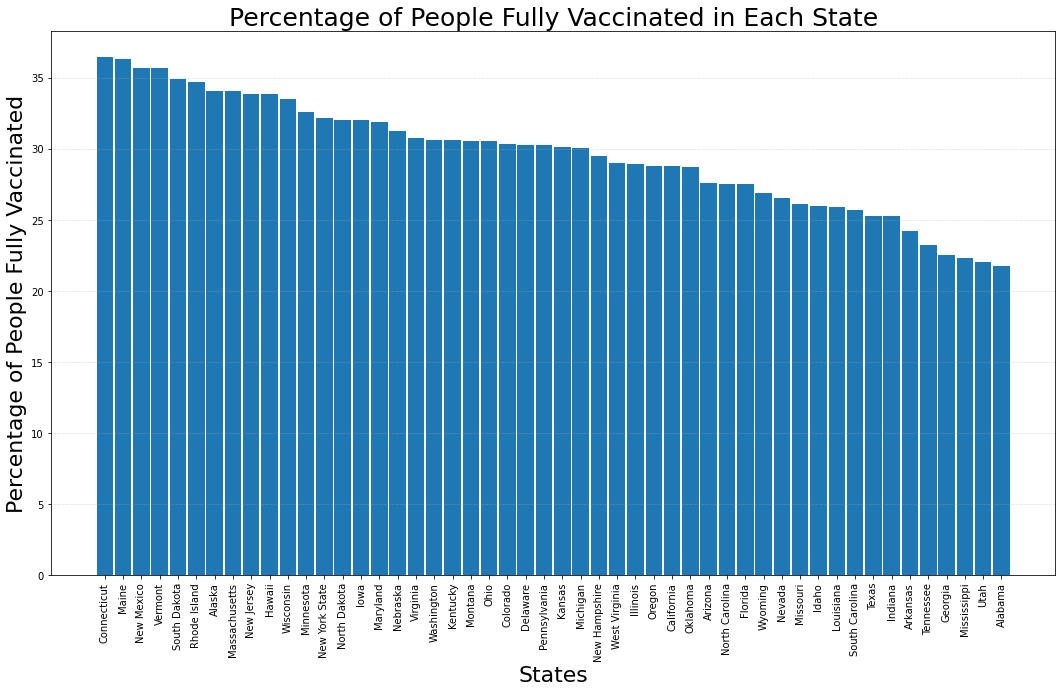

In [15]:
sorted_fully_vaccinated = merged_states_vaccines.sort_values(by='people_fully_vaccinated_per_hundred',ascending=False)

plt.figure(figsize=(18,10))
plt.bar(sorted_fully_vaccinated['location'], sorted_fully_vaccinated['people_fully_vaccinated_per_hundred'],width=0.9)
plt.xlabel('States',fontsize=22)
plt.xticks(rotation = 90)
plt.ylabel('Percentage of People Fully Vaccinated',fontsize=22)
plt.title('Percentage of People Fully Vaccinated in Each State',fontsize=25)
plt.grid(axis='y',linestyle='dotted',linewidth=0.5,zorder=3)
plt.show()

## Question 5 : We want to see the  progression from the start of the pandemic to now the percent of people that have some immunity in the US. Produce a plot of weekly data that contains three lines. One showing the the percent of the living people have have or had covid. One showing the the percent of people that have had at least one covid vaccine shot. The third line showing the sum of the two to estimate the number of people that have some immunity. Over time sum will be an over estimate as people who had covid get a vaccine shot. As in #4 the notebook should download the data to up-to-date results.


In [16]:
# weekly count of cases and deaths data
weekly_cases_counts=daily_cases.loc[:,'2020-01-27'::7].sum(axis=0).to_frame()
weekly_cases_counts.columns=['Cases']
weekly_deaths_counts=daily_deaths.loc[:,'2020-01-27'::7].sum(axis=0).to_frame()
weekly_deaths_counts.columns=['Deaths']

In [17]:
# merging weekly cases and deaths data and finding persons that have or had covid
merged_weekly_cases_deaths = pd.merge(weekly_cases_counts,weekly_deaths_counts,left_index=True,right_index=True)
merged_weekly_cases_deaths['US Population'] = us_population
merged_weekly_cases_deaths['Have_or_Had_COVID']=merged_weekly_cases_deaths['Cases']-merged_weekly_cases_deaths['Deaths']
merged_weekly_cases_deaths['Have_or_Had_COVID_Percentage']=(merged_weekly_cases_deaths['Have_or_Had_COVID'])*100/merged_weekly_cases_deaths['US Population']

In [18]:
# Finding at least one vaccine shot results.
at_least_one_shot_dataset = daily_vaccines[daily_vaccines.location=='United States'].drop(['total_vaccinations','total_distributed',
        'people_fully_vaccinated_per_hundred','people_fully_vaccinated','location'],axis=1).ffill()
at_least_one_shot_dataset.set_index('date',inplace=True)
at_least_one_shot_weekly_dataset = at_least_one_shot_dataset.loc['2020-12-21'::7,].fillna(0)

In [19]:
US_merged_immunity_dataset = pd.merge(merged_weekly_cases_deaths,at_least_one_shot_weekly_dataset,how='left',left_index=True,right_index=True).fillna(0)
US_merged_immunity_dataset['Combined_Immunity_Percentage'] = (US_merged_immunity_dataset['Have_or_Had_COVID']+US_merged_immunity_dataset['people_vaccinated'])*100/us_population

### Answer 5 : Here is the Chart for question 5. It shows 3 lines. First showing weekly percent of the living people that have or had covid in US, second showing weekly percent of people that have had at least one covid vaccine shot in US and third showing weekly sum of the two to estimate the number of people that have some immunity. From the last line we can say that US reached around 35% immunity which is the half of considered herd immunity ( which is around 70% ).

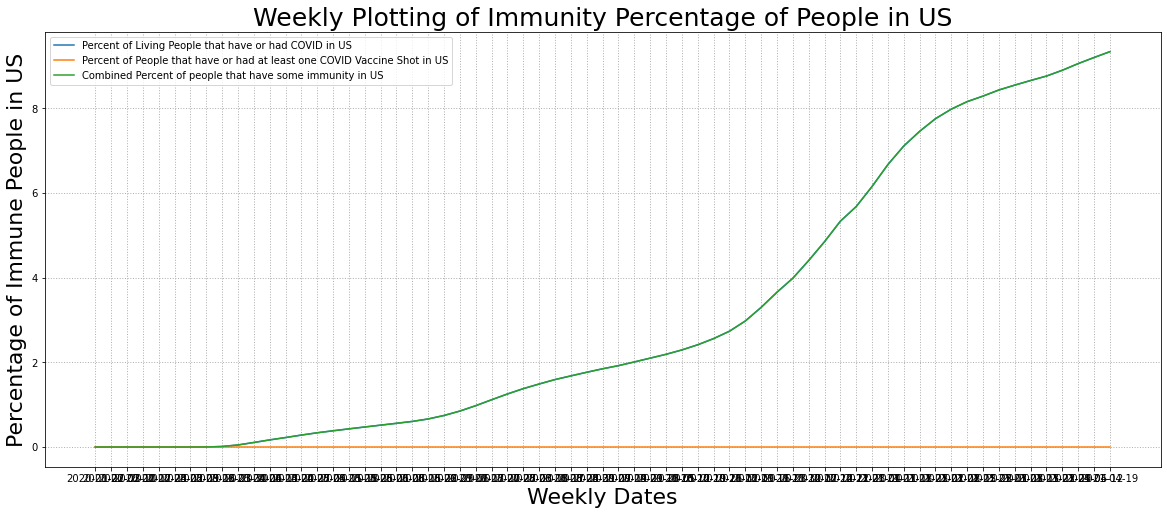

In [22]:
plt.figure(figsize=(20,8))
#plt.xticks(rotation = 90,ticks=US_merged_immunity_dataset.index,labels=US_merged_immunity_dataset.index.strftime('%Y-%m-%d'))
plt.plot(US_merged_immunity_dataset.index,US_merged_immunity_dataset['Have_or_Had_COVID_Percentage'],label='Percent of Living People that have or had COVID in US')
plt.plot(US_merged_immunity_dataset.index,US_merged_immunity_dataset['people_vaccinated_per_hundred'],label='Percent of People that have or had at least one COVID Vaccine Shot in US')
plt.plot(US_merged_immunity_dataset.index,US_merged_immunity_dataset['Combined_Immunity_Percentage'],label='Combined Percent of people that have some immunity in US')
plt.legend()
plt.xlabel('Weekly Dates',fontsize=22)
plt.ylabel('Percentage of Immune People in US',fontsize=22)
plt.title('Weekly Plotting of Immunity Percentage of People in US',fontsize=25)
plt.grid(linestyle='dotted',linewidth=1,zorder=3)
plt.show()

In [ ]:
## Missing one line -2, Had to comment out one line of code to make it run -1, are you saying only %8 are immune -2

In [23]:
# Creating only States data.
vaccines_state_only = daily_vaccines[(daily_vaccines['location']!='American Samoa') & (daily_vaccines['location']!='Guam') &
(daily_vaccines['location']!='Republic of Palau') & (daily_vaccines['location']!='Marshall Islands') & (daily_vaccines['location']!='Federated States of Micronesia') 
& (daily_vaccines['location']!='District of Columbia') & (daily_vaccines['location']!='Northern Mariana Islands')
& (daily_vaccines['location']!='Indian Health Svc') & (daily_vaccines['location']!='Puerto Rico')
& (daily_vaccines['location']!='Virgin Islands') & (daily_vaccines['location']!='Long Term Care') &
(daily_vaccines['location']!='Dept of Defense') & (daily_vaccines['location']!='United States') & 
(daily_vaccines['location']!='Bureau of Prisons') & (daily_vaccines['location']!='Veterans Health')]
vaccines_state_only['State_two_letter_code']=vaccines_state_only['location'].map(state_abbreviation)

/Users/whitney/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


## Question 6 : Produce the same plot  as in #5 for the  states. You should have a function that takes the two letter abbreviation for the state and produces the plot for the state.

In [24]:
weekly_cases=daily_cases.loc[:,'2020-01-27'::7]
weekly_deaths=daily_deaths.loc[:,'2020-01-27'::7]

In [25]:
state_population_only=county_population.groupby('State').sum()

### Here is the funtion definition that will take 2 letter abbreviation code for the state and produces the plot for the particular state.

In [28]:
def immunity_plot(state_name): 
    
    weekly_cases_statewise=weekly_cases[weekly_cases.index==state_name].groupby('State').sum().T
    weekly_deaths_statewise=weekly_deaths[weekly_deaths.index==state_name].groupby('State').sum().T
    
    combined_weekly_data=pd.merge(weekly_cases_statewise,weekly_deaths_statewise,left_index=True,right_index=True).rename(columns={'{}_x'.format(state_name):'Cases','{}_y'.format(state_name):'Deaths'})
    combined_weekly_data.index.names=['Date']    
    combined_weekly_data['Have_or_Had_COVID']=combined_weekly_data['Cases']-combined_weekly_data['Deaths']
    
    state_population_total = pd.Series(state_population_only[state_population_only.index==state_name]['population']).values[0]
    combined_weekly_data['Have_or_Had_COVID_Percentage'] = combined_weekly_data['Have_or_Had_COVID']*100/state_population_total
    
    state_alone_total_vaccines=vaccines_state_only[vaccines_state_only['State_two_letter_code']==state_name].ffill()
    state_alone_total_vaccines.set_index('date',inplace=True)
    state_alone_total_vaccines.loc[dt.strptime('2021-01-11','%Y-%m-%d')]=['state',0,0,0,0,0,0,'{}'.format(state_name)]
    state_alone_total_vaccines.sort_index(inplace=True)
    weekly_state_alone_total_vaccines = state_alone_total_vaccines.loc['2021-01-11'::7,].fillna(0)
    
    statewise_immunity_data = pd.merge(combined_weekly_data,weekly_state_alone_total_vaccines,how='left',left_index=True,right_index=True).fillna(0)
    statewise_immunity_data['Combined_Immunity_Percentage'] = (statewise_immunity_data['Have_or_Had_COVID']+statewise_immunity_data['people_vaccinated'])*100/state_population_total
    plt.figure(figsize=(25,10))
    #plt.xticks(rotation = 90,ticks=statewise_immunity_data.index,labels=statewise_immunity_data.index.strftime('%Y-%m-%d'))
    plt.plot(statewise_immunity_data.index,statewise_immunity_data['Have_or_Had_COVID_Percentage'],label='Percent of Living People that have or had COVID in {}'.format(state_name))
    plt.plot(statewise_immunity_data.index,statewise_immunity_data['people_vaccinated_per_hundred'],label='Percent of People that have or had at least one COVID Vaccine Shot in {}'.format(state_name))
    plt.plot(statewise_immunity_data.index,statewise_immunity_data['Combined_Immunity_Percentage'],label='Combined Percent of people that have some immunity in {}'.format(state_name))
    plt.legend()
    plt.xlabel('Weekly Dates',fontsize=22)
    plt.ylabel('Percentage of Immune People in {}'.format(state_name),fontsize=22)
    plt.title('Weekly Plotting of Immunity Percentage of People in {}'.format(state_name),fontsize=25)
    plt.grid(linestyle='dotted',linewidth=1,zorder=3)
    plt.show()

### Answer 6 : Here is the Function call for Question 6. You can put any 2 letter abbrivation code for state and it will generate weekly immunity percentage of people plot for that state. Just put any 2 letter state code in place of 'CA'.

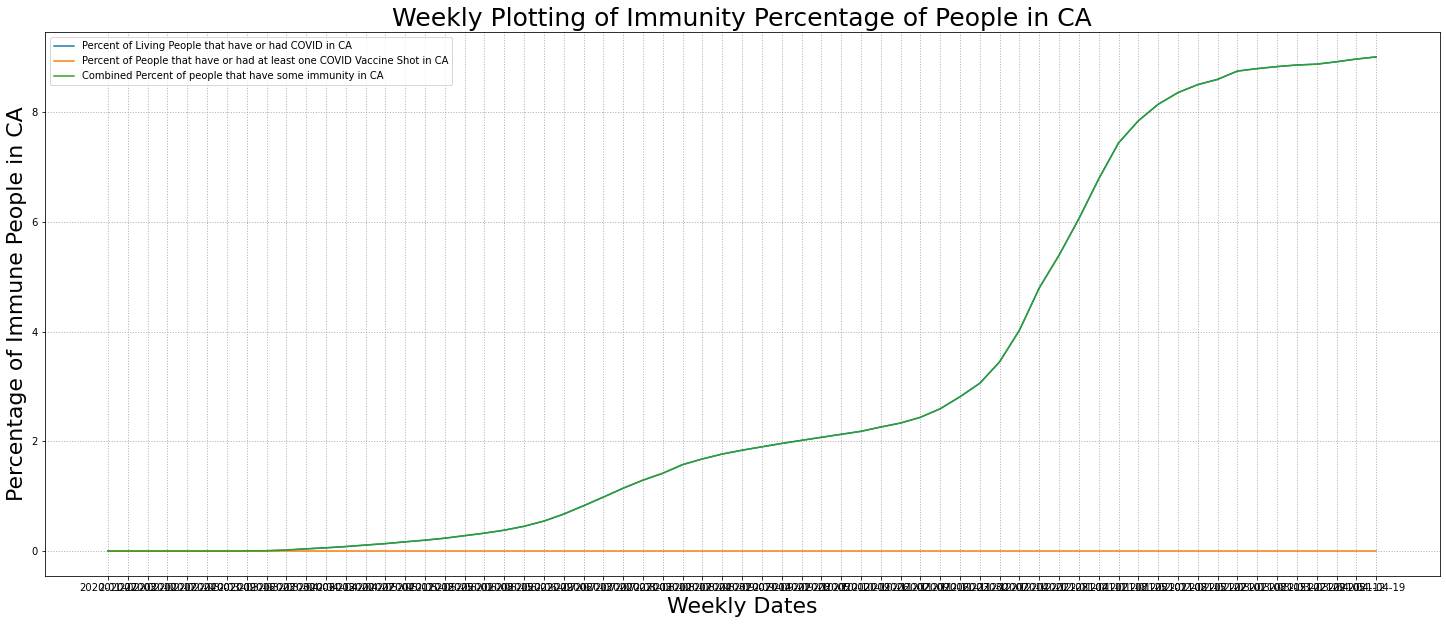

In [29]:
immunity_plot('CA')

## same issue with national -5

50/60